# Quality control for profiling analysis

Use this notebook to perform some quality checks of the profiling analysis.

In [45]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
# local
import luts
from config import data_dir
import analog_forecast as af
from run_naive_forecast import get_naive_sample_dates
from run_profile import forecast_and_error

Load and concatenate the results into single tables.

Analog and naive forecast results:

In [18]:
analog_df = pd.concat([
    pd.read_csv(fp) for fp in Path("results").glob("*.csv") 
    if (("naive" not in fp.name) and ("dates" not in fp.name))
])
naive_df = pd.concat([pd.read_csv(fp) for fp in Path("results").glob("*naive.csv")])

The top analogs were saved as separate tables, combine those as well:

In [112]:
analog_dates = pd.concat([
    pd.read_csv(fp, dtype=dict(analog_score=np.float32)) 
    for fp in Path("results").glob("*dates.csv")
])

## QC

### Analog profiling

Here we will validate the analog forecast profiling results. Let's take the first result (row) and manually check each aspect of the algorithm.

In [4]:
row = analog_df.iloc[0]
row

variable                      sst
search_domain              alaska
forecast_domain            alaska
anomaly_search               True
reference_date         2004-10-08
forecast_day_number             1
forecast_error              1.331
Name: 0, dtype: object

Load the ERA5 data that we will use to search and generate forecasts:

In [5]:
%%time
varname = row["variable"]
ref_date = row["reference_date"]
ds = xr.load_dataset(data_dir.joinpath(luts.varnames_lu[varname]["anom_filename"]))

CPU times: user 263 ms, sys: 35.1 s, total: 35.4 s
Wall time: 52.5 s


Subset to the spatial domain:

In [6]:
search_domain = row["search_domain"]
search_bbox = luts.spatial_domains[search_domain]["bbox"]
search_da = ds[varname].sel(
    latitude=slice(search_bbox[3], search_bbox[1]),
    longitude=slice(search_bbox[0], search_bbox[2])
)
print("Original shape:", ds[varname].shape)
print("Shape after spatial subset:", search_da.shape)

Original shape: (23011, 361, 1440)
Shape after spatial subset: (23011, 129, 221)


Find the analogs from the search data:

In [7]:
%%time
analogs = af.find_analogs(search_da, ref_date=ref_date)

CPU times: user 3.66 s, sys: 7.85 s, total: 11.5 s
Wall time: 11.5 s


Check that the analogs found here match what was found in the skill profiling framework:

In [8]:
profile_dates = analog_dates.query(
    (
        "variable == @varname" 
        "& search_domain == @search_domain"
        f"& forecast_domain == '{row['forecast_domain']}'"
        f"& anomaly_search == {row['anomaly_search']}"
        f"& reference_date == '{row['reference_date']}'"
    )
).analog_date.values
check_dates = analogs.time.dt.strftime("%Y-%m-%d").values

assert all(check_dates == profile_dates)

Load the raw value version for generating and checking the forecast:

In [9]:
%%time
raw_ds = xr.load_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))

CPU times: user 1min 9s, sys: 1min 29s, total: 2min 38s
Wall time: 2min 39s


Subset the raw data spatially and compute the forecast as the mean of the arrays for day t+1 for each of the analogs:

In [10]:
forecast_domain = row["forecast_domain"]
forecast_bbox = luts.spatial_domains[forecast_domain]["bbox"]
raw_da = raw_ds[varname].sel(
    latitude=slice(forecast_bbox[3], forecast_bbox[1]),
    longitude=slice(forecast_bbox[0], forecast_bbox[2])
)
forecast = (raw_da.sel(time=analogs.time.values + pd.to_timedelta(1, "d")).values).mean(axis=0)

Compute the RMSE between forecast and the date after the reference date, and cross check with the results:

In [11]:
test_rmse = np.sqrt(
    ((raw_da.sel(
        time=pd.to_datetime(ref_date + " 12:00:00") + pd.to_timedelta(1, "d")
    ) - forecast) ** 2).mean()
).round(3)

assert test_rmse == row["forecast_error"].astype(np.float32)

Make sure memory is freed up for loading different datasets:

In [12]:
import gc
try:
    del ds
    del raw_da
    del raw_ds
except:
    pass
gc.collect()

46

Do the same as above for other profiling results with some different variables, spatial domains, etc:

In [13]:
def validate_row(row):
    varname = row["variable"]
    ref_date = row["reference_date"]
    search_domain = row["search_domain"]
    search_bbox = luts.spatial_domains[search_domain]["bbox"]
    forecast_domain = row["forecast_domain"]
    forecast_bbox = luts.spatial_domains[forecast_domain]["bbox"]
    date_offset = row["forecast_day_number"]

    if row["anomaly_search"] == True:
        ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["anom_filename"]))
        search_da = af.spatial_subset(ds[varname], search_bbox)
        raw_ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
        raw_da = af.spatial_subset(raw_ds[varname], forecast_bbox)
    else:
        ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
        search_da = af.spatial_subset(ds[varname], search_bbox)
        raw_da = af.spatial_subset(ds[varname], forecast_bbox)

    analogs = af.find_analogs(search_da, ref_date=ref_date)
    
    # validate selected analog dates
    profile_dates = analog_dates.query(
        (
            "variable == @varname" 
            "& search_domain == @search_domain"
            "& forecast_domain == @forecast_domain"
            f"& anomaly_search == {row['anomaly_search']}"
            f"& reference_date == '{row['reference_date']}'"
        )
    ).analog_date.values
    check_dates = analogs.time.dt.strftime("%Y-%m-%d").values
    assert all(check_dates == profile_dates)
    
    # validate forecast error
    forecast = (raw_da.sel(time=analogs.time.values + pd.to_timedelta(date_offset, "d")).values).mean(axis=0)
    test_rmse = np.sqrt(
        ((raw_da.sel(
            time=pd.to_datetime(ref_date + " 12:00:00") + pd.to_timedelta(date_offset, "d")
        ) - forecast) ** 2).mean()
    ).round(3)
    assert test_rmse == row["forecast_error"].astype(np.float32)

In [14]:
%%time
row = analog_df.query("variable == 'sst'").iloc[-1]
validate_row(row)

CPU times: user 1min 11s, sys: 1min 49s, total: 3min 1s
Wall time: 3min 7s


In [15]:
%%time
row = analog_df.query("variable == 'msl'").iloc[300]
validate_row(row)

CPU times: user 8.48 s, sys: 25.9 s, total: 34.3 s
Wall time: 1min 4s


In [16]:
%%time
analog_df.query("variable == 'z'").iloc[500]
validate_row(row)

CPU times: user 5.62 s, sys: 8.51 s, total: 14.1 s
Wall time: 14.1 s


### Analog dates

Here we will validate the chosen analogs. This is technically part of the process tested above, but given some unexpectedly poor skill with the anomaly-based forecasts at the time of developing this section, we will have a closer look.



In [113]:
varname = "t2m"
ref_date = "2004-10-08"
search_domain = forecast_domain = "alaska"
trial_analogs = analog_dates.query((
    "variable == @varname & search_domain == @search_domain & "
    "forecast_domain == @forecast_domain & reference_date == @ref_date & anomaly_search == True"
))
trial_analogs

,variable,search_domain,forecast_domain,anomaly_search,reference_date,analog_date,analog_score
0,t2m,alaska,alaska,True,2004-10-08,2005-09-17,1.856
1,t2m,alaska,alaska,True,2004-10-08,1997-09-09,1.979
2,t2m,alaska,alaska,True,2004-10-08,2007-08-31,2.111
3,t2m,alaska,alaska,True,2004-10-08,2014-09-20,2.123
4,t2m,alaska,alaska,True,2004-10-08,2020-10-11,2.169


In [67]:
%%time
anom_ds = xr.open_dataset(data_dir.joinpath("era5_2m_temperature_anom_1959_2021.nc"))
search_bbox = luts.spatial_domains[search_domain]["bbox"]
search_da = af.spatial_subset(anom_ds[varname], search_bbox).load()

CPU times: user 645 ms, sys: 11.6 s, total: 12.2 s
Wall time: 53.1 s


In [102]:
%%time
test_analogs = af.find_analogs(search_da, ref_date=ref_date)

CPU times: user 2.99 s, sys: 3.45 s, total: 6.44 s
Wall time: 6.44 s


Verify that the top analogs match from the profiling runs:

In [126]:
assert np.all(test_analogs.values.round(3) == trial_analogs["analog_score"])
assert np.all(test_analogs.time.dt.strftime("%Y-%m-%d").values == trial_analogs["analog_date"])

Encapsulate this test in a function and run it for other trials:

In [131]:
def validate_dates(varname, ref_date, search_domain, forecast_domain, anom_search):
    trial_analogs = analog_dates.query((
        "variable == @varname & search_domain == @search_domain & "
        "forecast_domain == @forecast_domain & "
        "reference_date == @ref_date & anomaly_search == @anom_search"
    ))
    
    search_bbox = luts.spatial_domains[search_domain]["bbox"]
    forecast_bbox = luts.spatial_domains[forecast_domain]["bbox"]
    
    if anom_search == True:
        search_ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["anom_filename"]))
        search_da = af.spatial_subset(search_ds[varname], search_bbox)
        raw_ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
        raw_da = af.spatial_subset(raw_ds[varname], forecast_bbox)
    else:
        search_ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
        search_da = raw_da = af.spatial_subset(search_ds[varname], search_bbox)
        
    test_analogs = af.find_analogs(search_da, ref_date=ref_date)
    
    assert np.all(test_analogs.values.round(3) == trial_analogs["analog_score"])
    assert np.all(test_analogs.time.dt.strftime("%Y-%m-%d").values == trial_analogs["analog_date"])
    print("Pass")
        

In [132]:
%%time
validate_dates("t2m", "2011-11-04", "north_pacific", "alaska", False)

Pass
CPU times: user 41.3 s, sys: 50.5 s, total: 1min 31s
Wall time: 1min 31s


In [134]:
%%time
validate_dates("sst", "2004-10-15", "panarctic", "alaska", True)

Pass
CPU times: user 25.2 s, sys: 45.1 s, total: 1min 10s
Wall time: 2min 6s


In [135]:
%%time
validate_dates("msl", "2015-11-20", "northern_hs", "northern_hs", True)

Pass
CPU times: user 53.5 s, sys: 1min 39s, total: 2min 33s
Wall time: 2min 45s


### Naive forecast

Here we will check the naive forecast. Choose a particular forecast:

In [19]:
varname = "t2m"
forecast_domain = "alaska"
ref_date = "2011-11-06"
query_str = "forecast_domain == @forecast_domain & variable == @varname & reference_date == @ref_date"
naive_df.query(query_str).head()

,variable,forecast_domain,reference_date,forecast_day_number,naive_2.5,naive_50,naive_97.5
98,t2m,alaska,2011-11-06,1,2.934,4.066,6.874
99,t2m,alaska,2011-11-06,2,3.855,5.105,7.610
100,t2m,alaska,2011-11-06,3,3.939,5.151,7.489
101,t2m,alaska,2011-11-06,4,3.350,4.525,7.317
102,t2m,alaska,2011-11-06,5,3.358,4.340,7.248


In [20]:
raw_ds = xr.open_dataset(data_dir.joinpath(luts.varnames_lu[varname]["filename"]))
forecast_bbox = luts.spatial_domains[forecast_domain]["bbox"]
raw_da = af.spatial_subset(raw_ds[varname], forecast_bbox)

Get the naive sample dates:

In [21]:
naive_sample_dates = get_naive_sample_dates(raw_da.time.values, ref_date, n=1000)

Check that all naive sample analog dates are within 90-day window centered on the day-of-year of the reference date.

In [22]:
ref_doy = pd.to_datetime(ref_date).dayofyear
valid_doys = np.arange(ref_doy - 46, ref_doy + 46) # window is extended by day on each side in case of leap year

assert np.all([
    sample_analog in valid_doys 
    for rep in naive_sample_dates 
    for sample_analog in pd.to_datetime(naive_sample_dates[rep]["analogs"]).dayofyear
])

Compute forecasts for each repetition in naive_sample_dates:

In [24]:
%%time
results = [
    forecast_and_error(
        raw_da.sel(time=naive_sample_dates[rep]["all_dates"]),
        naive_sample_dates[rep]["analogs"],
        ref_date,
    )
    for rep in naive_sample_dates
]

CPU times: user 26.7 s, sys: 16.5 s, total: 43.3 s
Wall time: 53.5 s


Then summarize the error by computing the 2.5, 50, and 97.5 percentiles of error for each forecast day, like what is done for the profiling script:

In [25]:
sim_rmse = xr.concat(results, pd.Index(range(1000), name="sim"))

ref_err_df = pd.DataFrame({
    "variable": raw_da.name,
    "forecast_domain": forecast_domain,
    "reference_date": ref_date,
    "forecast_day_number": np.arange(14) + 1,
    "naive_2.5": sim_rmse.reduce(np.percentile, dim="sim", q=2.5),
    "naive_50": sim_rmse.reduce(np.percentile, dim="sim", q=50),
    "naive_97.5": sim_rmse.reduce(np.percentile, dim="sim", q=97.5),
})

Plot the differences between the profiling results and these newly computed values for each percentile. We want to see a mean of (probably?) about zero with the largest differences being small (<10% of percentile values?).

<AxesSubplot: >

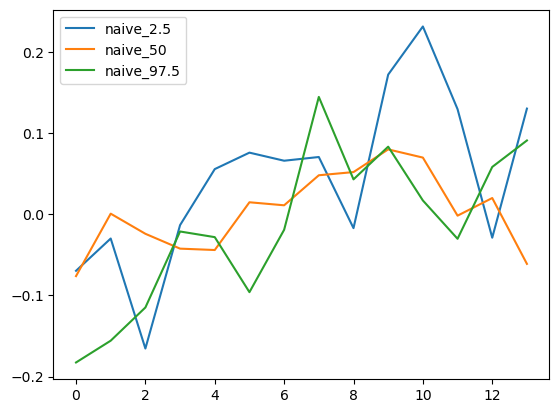

In [41]:
pcols = ["naive_2.5", "naive_50", "naive_97.5"]
(ref_err_df[pcols] - naive_df.query(query_str).reset_index(drop=True))[pcols].plot()

Okay, I think this is a good sign for our naive profiling results.